```{contents}
```
## **Split in LangGraph**

In LangGraph, a **Split** is a control-flow mechanism that **divides execution into multiple concurrent or independent paths** from a single node.
It enables **parallel reasoning, workload distribution, multi-agent collaboration, and map-style computation** within a stateful graph.

---

### **1. Motivation: Why Split Exists**

Complex AI systems often require:

| Requirement           | Explanation                         |
| --------------------- | ----------------------------------- |
| Parallel reasoning    | Explore multiple hypotheses at once |
| Multi-agent work      | Assign tasks to specialized agents  |
| Performance           | Reduce latency via concurrency      |
| Map-style computation | Apply same operation to many items  |
| Robustness            | Independent verification            |

The **Split** operation enables all of the above.

---

### **2. Conceptual Model**

```
                ┌── Worker A ──┐
Input ── Split ─┼── Worker B ──┼── Join ── Output
                └── Worker C ──┘
```

Split creates **multiple execution branches** that later **merge** using a **Join**.

---

### **3. How Split Works in LangGraph**

LangGraph implements Split via:

* **Fan-out edges** from one node
* **Independent execution contexts**
* **Shared global state**
* **Join / reducer functions** for merging results

There is **no explicit "Split node"**; instead, Split is created by wiring edges.

---

### **4. Minimal Working Example — Parallel Workers**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict, List

class State(TypedDict):
    tasks: List[str]
    results: List[str]

def dispatcher(state):
    return {}

def worker_a(state):
    return {"results": ["A processed"]}

def worker_b(state):
    return {"results": ["B processed"]}

builder = StateGraph(State)

builder.add_node("dispatch", dispatcher)
builder.add_node("worker_a", worker_a)
builder.add_node("worker_b", worker_b)

builder.set_entry_point("dispatch")

# --- Split ---
builder.add_edge("dispatch", "worker_a")
builder.add_edge("dispatch", "worker_b")

# --- Join ---
builder.add_edge("worker_a", END)
builder.add_edge("worker_b", END)

graph = builder.compile()
print(graph.invoke({"tasks": [], "results": []}))
```

Execution paths:

```
dispatch → worker_a → END
dispatch → worker_b → END
```

Results merge automatically via state reducers.

---

### **5. Split with Join & Reducers**

To safely merge parallel outputs, use a **reducer**:

```python
from operator import add

class State(TypedDict):
    results: list

State.__annotations__["results"] = list[str]
builder = StateGraph(State, reducers={"results": add})
```

This ensures:

```
["A processed"] + ["B processed"] → ["A processed", "B processed"]
```

---

### **6. Conditional Split**

Split based on runtime decision:

```python
def router(state):
    if len(state["tasks"]) > 3:
        return ["worker_a", "worker_b"]
    return ["worker_a"]

builder.add_conditional_edges("dispatch", router)
```

---

### **7. Common Split Patterns**

| Pattern            | Purpose                           |
| ------------------ | --------------------------------- |
| Map-Reduce         | Process many items then aggregate |
| Multi-Agent        | Specialists work in parallel      |
| Ensemble Reasoning | Generate multiple answers         |
| Verification       | One path solves, another checks   |
| Search             | Explore solution space            |

---

### **8. Production Considerations**

| Concern             | Solution           |
| ------------------- | ------------------ |
| Race conditions     | Use reducers       |
| State corruption    | Immutable updates  |
| Resource exhaustion | Concurrency limits |
| Debugging           | Trace each branch  |
| Latency control     | Parallelism tuning |

---

### **9. Mental Model**

Split transforms LangGraph from a **pipeline** into a **parallel computation graph**:

> **One state → many workers → one combined state**

This is fundamental for building **scalable, agentic, and high-performance LLM systems**.


### Demonstration

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Annotated
from operator import add

# -----------------------------
# 1. Define shared state with reducer
# -----------------------------
class State(TypedDict):
    input: str
    results: Annotated[List[str], add]   # <-- enables safe parallel merge

# -----------------------------
# 2. Nodes
# -----------------------------
def dispatcher(state):
    print("Dispatching work...")
    return {}

def worker_a(state):
    print("Worker A processing")
    return {"results": ["Result from A"]}

def worker_b(state):
    print("Worker B processing")
    return {"results": ["Result from B"]}

# -----------------------------
# 3. Build graph
# -----------------------------
builder = StateGraph(State)

builder.add_node("dispatch", dispatcher)
builder.add_node("worker_a", worker_a)
builder.add_node("worker_b", worker_b)

builder.set_entry_point("dispatch")

# ---- Split (fan-out) ----
builder.add_edge("dispatch", "worker_a")
builder.add_edge("dispatch", "worker_b")

# ---- Join (fan-in) ----
builder.add_edge("worker_a", END)
builder.add_edge("worker_b", END)

graph = builder.compile()

# -----------------------------
# 4. Run
# -----------------------------
final_state = graph.invoke({"input": "start", "results": []})

print("\nFinal merged state:")
print(final_state)


Dispatching work...
Worker A processing
Worker B processing

Final merged state:
{'input': 'start', 'results': ['Result from A', 'Result from B']}


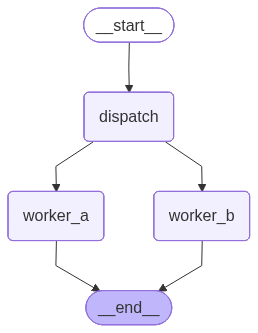

In [3]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())